In [3]:
import numpy as np
import regex as re
import pandas as pd
import pickle
from collections import defaultdict


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib import colors
from matplotlib.lines import Line2D


#from netwulf import visualize
#import netwulf as nw
#from numba import jit

#import pydot

from fa2 import ForceAtlas2
from graph_functions import create_bipartite_graph, set_politician_attributes, create_color_map
import networkx as nx
#import community for community detection
import community as community_louvain

### Goal: investigate which politicians are present the entire time for each period and establish some threshold to remove nodes that are not sufficiently present

In [4]:
#load data from df_law_clean.pickle
with open('df_law_clean.pickle', 'rb') as f:
    df = pickle.load(f)


In [5]:
df.head()

,afstemnings_id,dato_sagstrin,sag_id,titel,titel_kort,lovnummer_num,resume,periode_id,votes_combined_info,votes_adjusted,afstemnings_id_pfix,law_category,law_category_id,law_category_clean
0,2,2014-09-09T09:15:00,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,Loven ændrer virksomhedsskatteordningens regle...,32,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '...","[{'id': 180, 'typeid': 1, 'afstemningid': 2, '...",p2,"[Skatter og afgifter 70, virksomhedsskat]","[33062, 33754]","[Skatter og afgifter, virksomhedsskat]"
1,4,2012-11-06T00:00:00,5904,Forslag til lov om akutjob og jobpræmie til ar...,Om akutjob.,46,"Med loven etableres en midlertidig ordning, så...",31,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4...","[{'id': 850407, 'typeid': 1, 'afstemningid': 4...",p4,"[akutjob og jobpræmie til arbejdsgivere, polit...","[62218, 34460, 33270, 33070]","[akutjob og jobpræmie til arbejdsgivere, polit..."
2,5,2014-09-09T09:15:00,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,Loven ændrer virksomhedsskatteordningens regle...,32,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5...","[{'id': 164665, 'typeid': 1, 'afstemningid': 5...",p5,"[Skatter og afgifter 70, virksomhedsskat]","[33062, 33754]","[Skatter og afgifter, virksomhedsskat]"
3,9,2014-06-11T09:00:00,1451,Forslag til lov om ændring af lov om trafiksel...,Om Region Nordjyllands overtagelse af statens ...,136,"Med loven åbnes der mulighed for, at Region No...",32,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9...","[{'id': 163591, 'typeid': 4, 'afstemningid': 9...",p9,"[kollektiv transport, transportpolitik]","[33056, 33086]","[kollektiv transport, transportpolitik]"
4,10,2014-06-11T09:00:00,780,Forslag til lov om projektering af nyanlæg og ...,Om nyanlæg og hastighedsopgraderinger af jernb...,172,"Loven indeholder bemyndigelse til, at transpor...",32,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1...","[{'id': 163770, 'typeid': 1, 'afstemningid': 1...",p10,"[politisk aftale, projektering af nyanlæg og h...","[34460, 84356, 83647, 33917, 33364]","[politisk aftale, projektering af nyanlæg og h..."


In [6]:
#take a subset of the data for period 32
df32 = df[df['periode_id'] == 32]

In [7]:
df31 = df[df['periode_id'] == 31]

In [8]:

#initialize defaultdict for politicians
dict_politicians = defaultdict()

#for each row, go through votes_adjusted and check which aktørid is in the list. If new, add to a dict of politicians, if not, add 1 to the count of that politician

for index, row in df32.iterrows():
    for vote in row['votes_adjusted']:
        if vote['aktørid'] not in dict_politicians:
            dict_politicians[vote['aktørid']] = 1
        else:
            dict_politicians[vote['aktørid']] += 1

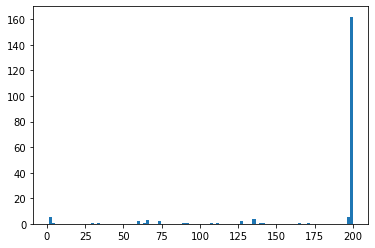

In [9]:
#make a histogram of the number of votes per politician
plt.hist(dict_politicians.values(), bins=100)
plt.show()


### The problem of politicians that have only been part of a portion of a given period - scewed data
Since we are creating a unipartite graph and relying on the weights between politicians in a given period to determine how much they collaborate, based solely on the shared amount of 'yes votes', it is a problem if we have some politicians in our dataset with very few votes in a given period. Hence, not having voting, counts equally much against being in a community with a yes voter, as simply not being present. One way to fix this, would be to set some empirical values as to influence the weight so that a yes-no vote between two politicians for the same law provides a more negative score, than a yes-absent. 

Even with weighting the vote types, we are however still faced with the problem of politicians that have less than 100% votes when including both yes, no, absent and blank votes. This could happen if there was some mistake in the registration of votes, but will certaintly happen when a politician due to serius sickness, maternity leave, quitting etc. is no longer part of the parlaimentary work, or when a substitution enters in midst of a period. If we include politicians that for whatever reason may just have participated in some % of the votings that year, we expect that this wil scew our community detection significantly as the weights will make it appear as if this person disagree with the majority of the other politicians that they in fact agreed with (given that much fewer edges will be created for a politician that did fewer votings). 

A solution would be to scale the weight of the edges in a network, based on the % of total votings they have been part of in that given period (including both absent, blank, yes and no votes), or simply remove politicians that have only been partially involved in the votings for a given year (perhaps at some reasonable threshold).

### Removing politicians that have not participated in the majorty of votings
We decided to proceed with the approach of removing politicians

In [10]:
#after having check a few periods, it seems to make sense to make a threshold at 90% of max votes
threshold = 0.9 * max(dict_politicians.values())

In [11]:
#This function takes a periode_id and calculates the 90% threshold for that period
def threshold_periode(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    return 0.9 * max(dict_politicians.values())


In [12]:
#This function takes a periode_id and returns a list of politicians who have voted more than 90% of the time
def active_politicians(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    threshold = 0.9 * max(dict_politicians.values())

    return [key for key, value in dict_politicians.items() if value > threshold]

In [13]:
#This function does the same as above, but without the threshold
def all_politicians(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    return [key for key, value in dict_politicians.items()]

In [14]:
#We find all unique periode_ids
periode_ids = df['periode_id'].unique()

#We make a dict of active politicians for each periode_id
dict_active_politicians = defaultdict()
for periode_id in periode_ids:
    dict_active_politicians[periode_id] = active_politicians(periode_id)


In [15]:
#We make a new pandas dataframe, where we go through votes_adjusted and only keep the votes from active politicians
df_active = pd.DataFrame(columns=['periode_id', 'votes_adjusted'])
for index, row in df.iterrows():
    votes_adjusted = row['votes_adjusted']
    votes_adjusted = [vote for vote in votes_adjusted if vote['aktørid'] in dict_active_politicians[row['periode_id']]]
    df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)


C:\Users\soilsense\AppData\Local\Temp\ipykernel_20852\2555559439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)
C:\Users\soilsense\AppData\Local\Temp\ipykernel_20852\2555559439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)
C:\Users\soilsense\AppData\Local\Temp\ipykernel_20852\2555559439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)
C:\Users\soilsense\AppData\Loca

In [16]:
df_active.head()

,periode_id,votes_adjusted
0,32,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
1,31,"[{'id': 850408, 'typeid': 1, 'afstemningid': 4..."
2,32,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
3,32,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9..."
4,32,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1..."


In [17]:
#Initialize defaultdict for politicians
politicians_lost = defaultdict()
politicians_active = defaultdict()

for period in periode_ids:
    #Number of politicans who voted in each vote
    all_pol = all_politicians(period)
    active_pol = active_politicians(period)
    politicians_lost[period] = len(all_pol) - len(active_pol)
    politicians_active[period] = len(active_pol)


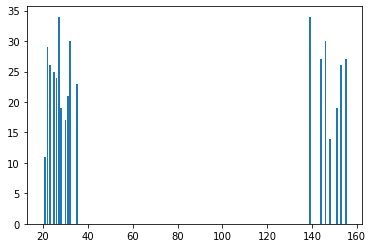

The average number of politicians dropped per period is 19.818181818181817


In [18]:
#Make a histogram of the number of politicians lost per period with periode_id as x-axis
plt.bar(politicians_lost.keys(), politicians_lost.values())
plt.show()
print('The average number of politicians dropped per period is', np.mean(list(politicians_lost.values())))

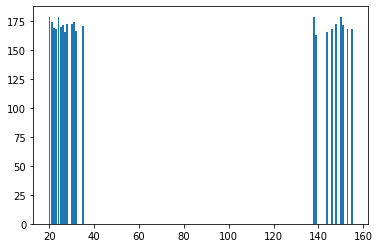

The average number of politicians that we consider per period is 171.4090909090909


In [19]:
#Make a histogram of the number of active politicians with periode_id as x-axis
plt.bar(politicians_active.keys(), politicians_active.values())
plt.show()
print('The average number of politicians that we consider per period is', np.mean(list(politicians_active.values())))

Given that there are at any time 179 politicians in the parlaiment, we believe that by sorting off less than 8 politicians pr. period on average, our data analysis will still be representative. 

In [20]:
#append a column to df from df_active, where we have the votes_adjusted from df_active
df['votes_adjusted_active'] = df_active['votes_adjusted']
#drop vote_combined to save memory so we can push to github
df.drop(columns=['votes_combined_info'], inplace=True)

In [21]:
#pickle the new dataframe
with open('df_law_active.pickle', 'wb') as f:
    pickle.dump(df, f)

In [30]:
#create a networkx graph for period 32
df32 = df[df['periode_id'] == 32]

G = create_bipartite_graph(df32)

#set attributes for politicians
G = set_politician_attributes(G)

In [26]:
#Function to check for isolate nodes
def remove_isolate_nodes(G):
    isolate_nodes = list(nx.isolates(G))
    if len(isolate_nodes) > 0:
        G.remove_nodes_from(isolate_nodes)
        print(f'Removed {len(isolate_nodes)} isolate nodes')
    else:
        print('No isolate nodes')
    return G

In [27]:
#clean graph
#remove the isolated nodes
remove_isolate_nodes(G)

law_nodes, politician_nodes = nx.bipartite.sets(G)

color_map = create_color_map() #defined in graph_functions.py

No isolate nodes


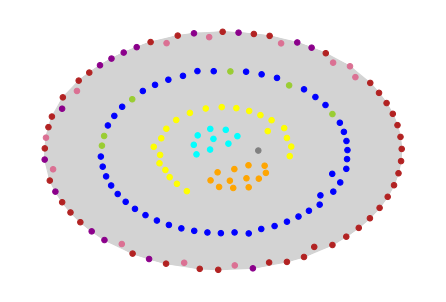

In [28]:
G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

pos = nx.kamada_kawai_layout(G_uni)
#pos = nx.fruchterman_reingold_layout(G_uni, k=0.5, iterations=50)

nx.draw(G_uni, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()])

In [32]:
#Do clustering on the graph using the Louvain algorithm
partition = community_louvain.best_partition(G_uni)

#print number of clusters
print(len(set(partition.values())))


3


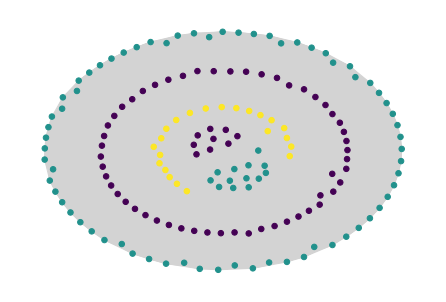

In [33]:
#plot the graph with the clusters
pos = nx.kamada_kawai_layout(G_uni)

nx.draw(G_uni, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_uni.nodes()])
plt.show()

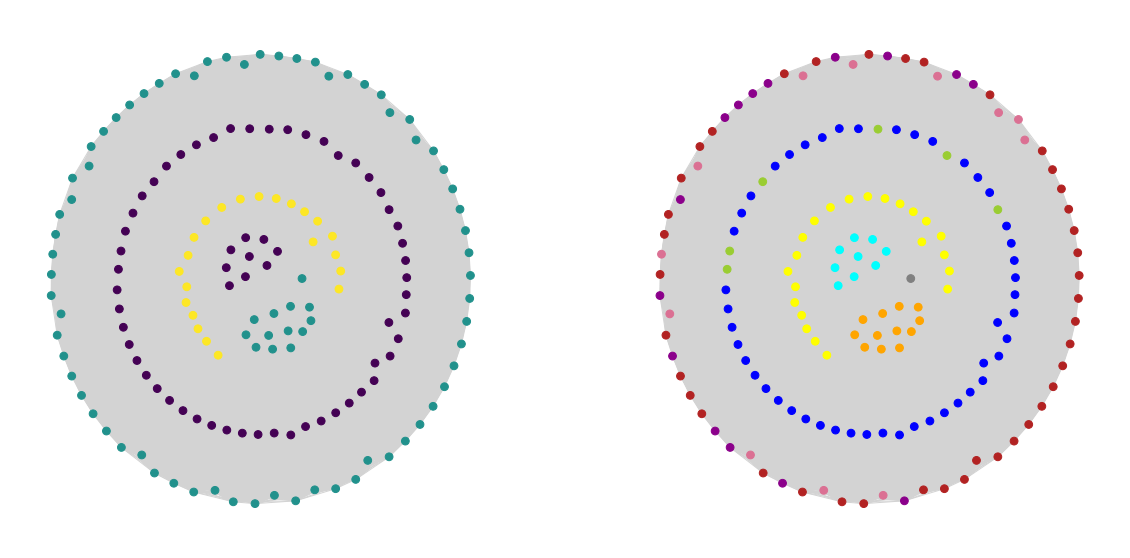

In [35]:
#plot the graph with the clusters in a subgraph
#two horizontally stacked subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#plot the networkx graph in ax1 
pos = nx.kamada_kawai_layout(G_uni, weight='weight', scale=100)
nx.draw(G_uni, node_size = 60, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_uni.nodes()], ax=ax1)
#plot it with party colors
nx.draw(G_uni, node_size = 60, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()], ax=ax2)

In [37]:
df32.head()

,afstemnings_id,dato_sagstrin,sag_id,titel,titel_kort,lovnummer_num,resume,periode_id,votes_adjusted,afstemnings_id_pfix,law_category,law_category_id,law_category_clean,votes_adjusted_active
0,2,2014-09-09T09:15:00,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,Loven ændrer virksomhedsskatteordningens regle...,32,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '...",p2,"[Skatter og afgifter 70, virksomhedsskat]","[33062, 33754]","[Skatter og afgifter, virksomhedsskat]","[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
2,5,2014-09-09T09:15:00,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,Loven ændrer virksomhedsskatteordningens regle...,32,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5...",p5,"[Skatter og afgifter 70, virksomhedsskat]","[33062, 33754]","[Skatter og afgifter, virksomhedsskat]","[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
3,9,2014-06-11T09:00:00,1451,Forslag til lov om ændring af lov om trafiksel...,Om Region Nordjyllands overtagelse af statens ...,136,"Med loven åbnes der mulighed for, at Region No...",32,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9...",p9,"[kollektiv transport, transportpolitik]","[33056, 33086]","[kollektiv transport, transportpolitik]","[{'id': 163591, 'typeid': 4, 'afstemningid': 9..."
4,10,2014-06-11T09:00:00,780,Forslag til lov om projektering af nyanlæg og ...,Om nyanlæg og hastighedsopgraderinger af jernb...,172,"Loven indeholder bemyndigelse til, at transpor...",32,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1...",p10,"[politisk aftale, projektering af nyanlæg og h...","[34460, 84356, 83647, 33917, 33364]","[politisk aftale, projektering af nyanlæg og h...","[{'id': 163770, 'typeid': 1, 'afstemningid': 1..."
5,11,2014-06-11T09:00:00,1118,Forslag til lov om ændring af lov om befordrin...,Om befordringsrabat til studerende ved videreg...,187,Befordringsordningerne for studerende ved de v...,32,"[{'id': 163949, 'typeid': 1, 'afstemningid': 1...",p11,"[SU-loven, befordringsrabat til studerende ved...","[38438, 62437, 46669, 34460, 84366, 33537, 33322]","[SU-loven, befordringsrabat til studerende ved...","[{'id': 163949, 'typeid': 1, 'afstemningid': 1..."


In [40]:
#Who is the grey (out of folketingsgruppe) politician?
for node in G_uni.nodes():
    if G_uni.nodes[node]['color'] == 'grey':
        #print name attribute of the node
        print(G_uni.nodes[node]['name'])

Uffe Elbæk


In [41]:
#Uffe Elbæk left radikale venstre in 2013, and this period covers 2014-2015 - makes sense.

In [87]:
#import backbone
import backbone_network as bb

#make a backbone network
G_backbone = bb.get_graph_backbone(G_uni, 0.5)


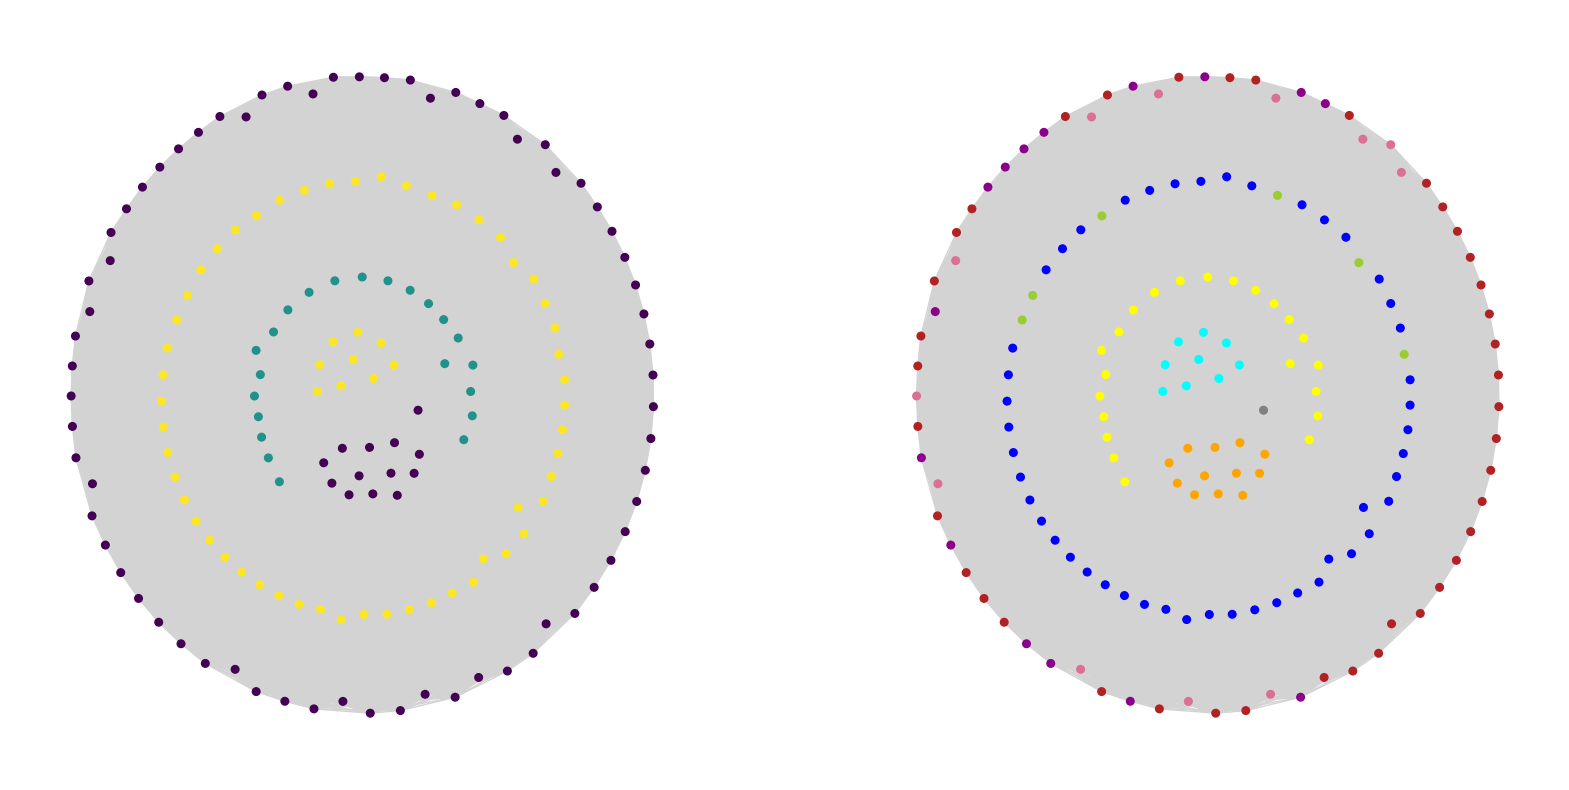

In [89]:
#plot the backbone network
pos = nx.kamada_kawai_layout(G_backbone, weight='weight', scale=100)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
nx.draw(G_backbone, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_backbone.nodes()], ax=ax1)
nx.draw(G_backbone, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_backbone.nodes[node]['color'] for node in G_backbone.nodes()], ax=ax2)


In [ ]:
#find the node with uknown party
for node in G_uni.nodes():
    if G_uni.nodes[node]['party'] == 'Ukendt':
        print(node)